# Logistic Regression (MNIST)
### (preliminary: logistic model)
## 1. Library, Data, Preprocessing (Split, Normalize)
## 2. Solve logistic model with Pytorch
## 3. Show the result with confusion matrix

# Library

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

import torchvision.datasets as dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("device: gpu") if torch.cuda.is_available() else print("device: cpu")

device: gpu


# Hyper parameter setting

In [2]:
# hypter parameter setting
learning_rate = 1e-1 # 0.1
epochs = 50
batch_size = 60000 # gradient descent
display_step = 10

# Load data

100.1%

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


113.5%

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


100.4%

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


180.4%/home/pirl/anaconda3/envs/pytorch/lib/python3.7/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!
len(train_data):  60000
len(test_data):  10000
data shape:  torch.Size([1, 28, 28])
label:  5


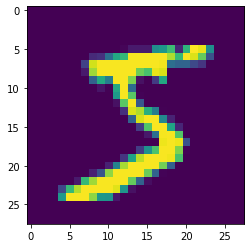

In [3]:
# load data (target_transform: one-hot encoding)
train_data = dataset.MNIST("./", train = True, transform = transforms.ToTensor(), target_transform = None, download = True)
test_data = dataset.MNIST("./", train = False, transform = transforms.ToTensor(), target_transform = None, download = True)

# check the data
print('len(train_data): ', len(train_data))
print('len(test_data): ', len(test_data))

x_train, y_train = train_data[0]
print('data shape: ', x_train.shape)
print('label: ', y_train)

plt.figure()
plt.imshow(x_train[0])
plt.show()

## Pre-process

batch_idx:  0
data shape: torch.Size([60000, 1, 28, 28])
label: tensor([6, 4, 2,  ..., 0, 1, 3])


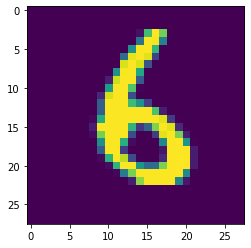

In [7]:
# Pre-process (batch, shuffle)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 1, drop_last = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 10000, shuffle = True, num_workers = 1, drop_last = True)

# check the data 
examples = enumerate(train_loader)
batch_idx, (example_data, example_target) = next(examples)

print('batch_idx: ', batch_idx)
print('data shape:', example_data.shape)
print('label:', example_target)

plt.figure()
plt.imshow(example_data[0][0])
plt.show()

# Make model with pytorch (Gradient Descent)

In [8]:
# model
model = nn.Linear(784,10)
model = model.to(device)
model.train() # train 할 건지 test 할 건지 알려줘야 함

# loss and optimizer 
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

loss_array = []

# train the model
for epoch in range(epochs):
    for iteration, [data, label] in enumerate(train_loader):
        optimizer.zero_grad() # gradient 초기화
        
        x = data.to(device) 
        x = x.view(batch_size, -1) # such as reshape
        y = label.to(device)
        
        # forward
        output = model(x)
        loss = loss_function(output, y) # 자동으로 one-hot encoding 수행해줌

        # backward
        loss.backward()
        optimizer.step()
            
        loss_array.append(loss.cpu().detach().numpy())
    
    if epoch % 10 == 0:
        print("Epoch:", epoch + 1, "\Loss:", loss)

Epoch: 1 \Loss: tensor(2.3160, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch: 11 \Loss: tensor(1.5526, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch: 21 \Loss: tensor(1.1913, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch: 31 \Loss: tensor(0.9974, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch: 41 \Loss: tensor(0.8789, device='cuda:0', grad_fn=<NllLossBackward>)


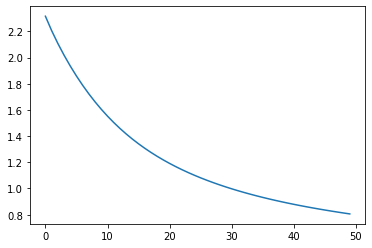

In [9]:
plt.figure()
plt.plot(loss_array)
plt.show()

# Test

In [10]:
# test
model.eval() # for test
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 10000, shuffle = True, num_workers = 1, drop_last = True)
correct = 0
total = 0

prediction_list = [] # for confusion matrix
label_list = [] # for confusion matrix

with torch.no_grad():
    for data, label in test_loader:
        x = data.to(device)
        x = x.view(-1, 784)
        y = label.to(device)
        
        prediction = model(x)
        _, prediction_index = torch.max(prediction, 1)
                
        prediction_list.append(prediction_index)
        label_list.append(y)
        
        total += y.size(0)
        correct += (prediction_index == y).sum().float()
        
print('total', total)
print('correct', correct)
print('accuracy', correct/total)

total 10000
correct tensor(8491., device='cuda:0')
accuracy tensor(0.8491, device='cuda:0')


# Confusion matrix

In [11]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
    
prediction_array = np.array(prediction_list[0].cpu())
label_array = np.array(label_list[0].cpu())

print("prediction :", prediction_array.shape)
print("true label :", label_array.shape)

confusion_matrix(
    label_array,
    prediction_array) # y_pred

prediction : (10000,)
true label : (10000,)


array([[ 934,    0,    4,    3,    0,    8,   21,    1,    9,    0],
       [   0, 1088,    7,    3,    1,    5,    4,    1,   26,    0],
       [  16,   37,  816,   31,   17,    0,   35,   22,   56,    2],
       [   6,    5,   23,  866,    1,   26,    9,   22,   35,   17],
       [   3,   12,    7,    0,  844,    0,   21,    2,   13,   80],
       [  34,   28,   11,  123,   31,  566,   26,   14,   38,   21],
       [  22,    7,   17,    1,   11,   18,  874,    0,    8,    0],
       [   5,   44,   24,    0,   12,    0,    2,  891,   13,   37],
       [  10,   24,   18,   52,   12,   18,   19,   15,  779,   27],
       [  18,   15,   10,   14,   62,    8,    3,   33,   13,  833]])